In [1]:
import csv
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression, f_classif, mutual_info_classif
from sklearn.metrics import mean_squared_error


# load the dataset
data = pd.read_csv('insa-ml-2024-regression/train.csv')

data.drop(columns=['hc', 'id'], inplace=True)


On remarque qu'il y a quelques valeurs de la colonne hcnox qui manquent (nan), lais que cette variable présente une forte correlation avec le fuel_type. On peut donc essayer de prédire les valeurs manquantes de hcnox en fonction du fuel_type.

In [5]:
median_hcnox_by_fuel_type = data.groupby('fuel_type')['hcnox'].median()

def fill_hcnox(row):
    if pd.isna(row['hcnox']):
        return median_hcnox_by_fuel_type[row['fuel_type']]
    else:
        return row['hcnox']

data['hcnox'] = data.apply(fill_hcnox, axis=1)

# delete rows where urban_cons is nan
data.dropna(subset=['urb_cons', 'exturb_cons'], inplace=True)

# replace nan values of hcnox by 0 if data['fuel_type'] contains the string 'EH' or 'ES' 
data.loc[data['fuel_type'].str.contains('EH|ES|GN'), 'hcnox'] = data.loc[data['fuel_type'].str.contains('EH|ES'), 'hcnox'].fillna(0)

# same thing with nox and co
data.loc[data['fuel_type'].str.contains('EH|ES'), 'nox'] = data.loc[data['fuel_type'].str.contains('EH|ES'), 'nox'].fillna(0)
data.loc[data['fuel_type'].str.contains('EH|ES'), 'co'] = data.loc[data['fuel_type'].str.contains('EH|ES'), 'co'].fillna(0)

# delete all rows that have nan values for co or nox but not containing 'EH' or 'ES' in fuel_type
data.dropna(subset=['nox', 'co'], inplace=True)

# replace all nan values in the dataframe by 0
data.fillna(0, inplace=True)

On encode ensuite les colonnes qui ont des valeurs non numériques. La librairie sklearn permet de faire cela facilement. On encode les colonnes qui ont des valeurs non numériques en utilisant la méthode `LabelEncoder` de la librairie `sklearn`.

In [15]:
# encoding categorical data
labelencoder = {}

categorical_cols = ['brand', 'model','car_class','range','fuel_type','hybrid','max_power','grbx_type_ratios']
for col in categorical_cols:
    labelencoder[col] = LabelEncoder()
    data[col] = labelencoder[col].fit_transform(data[col])

La prochaine étape ensuite consistera en le choix des features qui sont intéressantes à considérer dans notre modèle.
Dans un premier temps, on prend toutes les features qui sont numériques. On utilise la méthode `SelectKBest` de la librairie `sklearn` pour sélectionner les features qui sont les plus importantes. On utilise ensuite la méthode `fit_transform` pour transformer les données en utilisant les features sélectionnées.

Les émissions de co2 étant l'objectif de notre étude, on isole la colonne afin selectionner les features pertinentes.

In [16]:
X = data.drop(columns=['co2'])
y = data['co2']

selector = SelectKBest(score_func= f_classif, k = 16)

X_selected = selector.fit_transform(X, y)

Ensuite on sépare les données en données d'entraînement et données de test. On utilise la méthode `train_test_split` de la librairie `sklearn` pour cela. On met le paramètre random_state à 0 pour s'assurer d'avoir des résultats reproductibles.

In [17]:
X_learn, X_test, y_learn, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=0)

# standardize the data
scaler = StandardScaler()
X_learn = scaler.fit_transform(X_learn)
X_test = scaler.transform(X_test)

Etant donné l'utilisation de pytorch, il faut convertir les données en tenseurs. On utilise la méthode `torch.tensor` pour cela.

In [18]:
X_train_tensor = torch.tensor(X_learn, dtype=torch.float32)
y_train_tensor = torch.tensor(y_learn.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

Il est temps de créer notre modèle de regression :D

In [19]:
class CO2PredictionModel(nn.Module):
    def __init__(self, input_dim) -> None:
        super(CO2PredictionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

La dernière étape consiste à entrainer le modèle sur les données de training

c:\Users\Nour\OneDrive - INSA Lyon\Documents\Cours\4A\S2\Machine Learning\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 0 - Train Loss: 41873.234375 - Validation Loss: 41792.7578125
Epoch 10 - Train Loss: 41798.2265625 - Validation Loss: 41715.58984375
Epoch 20 - Train Loss: 41680.578125 - Validation Loss: 41591.80859375
Epoch 30 - Train Loss: 41485.6796875 - Validation Loss: 41387.6953125
Epoch 40 - Train Loss: 41176.83984375 - Validation Loss: 41065.6171875
Epoch 50 - Train Loss: 40708.5703125 - Validation Loss: 40580.44921875
Epoch 60 - Train Loss: 40033.0078125 - Validation Loss: 39883.515625
Epoch 70 - Train Loss: 39090.4765625 - Validation Loss: 38915.44921875
Epoch 80 - Train Loss: 37826.6328125 - Validation Loss: 37623.19921875
Epoch 90 - Train Loss: 36195.8046875 - Validation Loss: 35962.6015625
Epoch 100 - Train Loss: 34165.4375 - Validation Loss: 33903.22265625
Epoch 110 - Train Loss: 31721.939453125 - Validation Loss: 31434.90625
Epoch 120 - Train Loss: 28893.900390625 - Validation Loss: 28590.451171875
Epoch 130 - Train Loss: 25750.658203125 - Validation Loss: 25443.103515625
Epoch 14

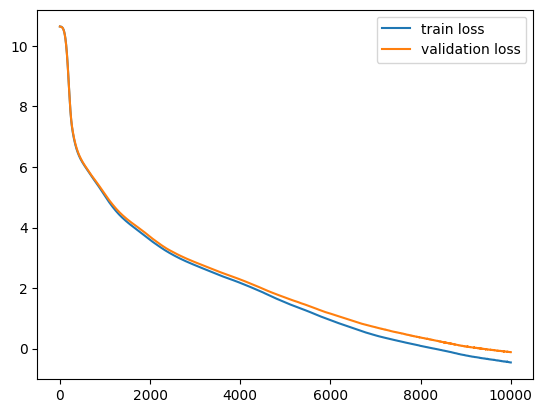

Test Loss: 0.8876019716262817


In [20]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from matplotlib import pyplot as plt

model = CO2PredictionModel(X_train_tensor.shape[1])
criterion = nn.MSELoss()

optimizer = optim.AdamW(model.parameters(), lr=0.001)

loss = +np.inf

train_losses = []
val_losses = []
# Training loop
epochs = 10000
epoch = 0

scheduler = ReduceLROnPlateau(optimizer, 'min', patience=20, verbose=True)

best_loss = float('inf')
patience = 0

while patience < 20 and epoch < epochs:    
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Model evalutaion on validation set
    with torch.no_grad():
        model.eval()
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)
    
    scheduler.step(val_loss)

    # Store training and validation losses
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if val_loss < best_loss:
        best_loss = val_loss
        patience = 0
    else:
        patience += 1

    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Train Loss: {loss.item()} - Validation Loss: {val_loss.item()}")
        
    epoch += 1

# plot in logarithmic scale
plt.plot(np.log(train_losses), label='train loss')
plt.plot(np.log(val_losses), label='validation loss')
plt.legend()
plt.show()

# Model Evaluation on Test Set
with torch.no_grad():
    model.eval()
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    print("Test Loss:", test_loss.item())
    

La dernière étape consiste à effectuer les prédictions sur les données de test et à évaluer la performance du modèle en utilisant la méthode `mean_squared_error` de la librairie `sklearn`.

In [21]:
test_data = pd.read_csv('insa-ml-2024-regression/test.csv')

test_data.fillna(0, inplace=True)

test_labelencoder = {}

for col in categorical_cols:
    test_labelencoder[col] = LabelEncoder()
    test_data[col] = test_labelencoder[col].fit_transform(test_data[col])
    
    
X_test_data = test_data[X.columns]

X_test_data_selected = selector.transform(X_test_data)
X_test_data_selected = scaler.transform(X_test_data_selected)

X_test_data_tensor = torch.tensor(X_test_data_selected, dtype=torch.float32)

with torch.no_grad():
    y_pred_tensor = model(X_test_data_tensor)
    y_pred = y_pred_tensor.numpy()

# save the predictions to a csv file
submission = pd.DataFrame({'id': test_data['id'], 'co2': y_pred.flatten()})
submission.to_csv('submission.csv', index=False)
    